<a href="https://colab.research.google.com/github/6sy666/deep-learning-for-image/blob/main/dl_hw1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorboardX

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 4.9 MB/s 


In [ ]:
!pip install torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tensorboardX import SummaryWriter
import os
import struct
import numpy as np
import random
from torchvision import transforms
from matplotlib import pyplot as plt
from PIL import Image
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


In [ ]:
from torchvision import datasets

In [ ]:
dir(datasets) 

['CIFAR10',
 'CIFAR100',
 'CLEVRClassification',
 'Caltech101',
 'Caltech256',
 'CelebA',
 'Cityscapes',
 'CocoCaptions',
 'CocoDetection',
 'Country211',
 'DTD',
 'DatasetFolder',
 'EMNIST',
 'EuroSAT',
 'FER2013',
 'FGVCAircraft',
 'FakeData',
 'FashionMNIST',
 'Flickr30k',
 'Flickr8k',
 'Flowers102',
 'FlyingChairs',
 'FlyingThings3D',
 'Food101',
 'GTSRB',
 'HD1K',
 'HMDB51',
 'INaturalist',
 'ImageFolder',
 'ImageNet',
 'KMNIST',
 'Kinetics',
 'Kinetics400',
 'Kitti',
 'KittiFlow',
 'LFWPairs',
 'LFWPeople',
 'LSUN',
 'LSUNClass',
 'MNIST',
 'Omniglot',
 'OxfordIIITPet',
 'PCAM',
 'PhotoTour',
 'Places365',
 'QMNIST',
 'RenderedSST2',
 'SBDataset',
 'SBU',
 'SEMEION',
 'STL10',
 'SUN397',
 'SVHN',
 'Sintel',
 'StanfordCars',
 'UCF101',
 'USPS',
 'VOCDetection',
 'VOCSegmentation',
 'VisionDataset',
 'WIDERFace',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_optical_flow',
 'caltech',
 '

In [ ]:
mnist_train=datasets.FashionMNIST(root='~/Datasets/FashionMNIST',train=True,transform=transforms.ToTensor(),download=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /root/Datasets/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/Datasets/FashionMNIST/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /root/Datasets/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/Datasets/FashionMNIST/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /root/Datasets/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/Datasets/FashionMNIST/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /root/Datasets/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/Datasets/FashionMNIST/FashionMNIST/raw



In [ ]:
def settle_seed(seed=42):
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.enabled = True
  print(seed)
settle_seed()


42


In [ ]:
def open_image(data_path):
    buffer = open(data_path,'rb').read()
    index = 0
    magic, numImages, numRows, numColumns = struct.unpack_from('>IIII', buffer, index)
    assert numRows == 28
    index += struct.calcsize('>IIII')
    data = []
    for i in range(numImages):
        im = struct.unpack_from('>784B', buffer, index)
        index += struct.calcsize('>784B')
        im = np.array(im).reshape(numRows,numColumns)
        data.append(im)
        # img = Image.fromarray(im.astype('uint8')).convert('RGB')
        # img.show()
    return data
def open_label(label_path):
    buffer = open(label_path,'rb').read()
    index = 0
    magic, numLabels = struct.unpack_from('>II', buffer, index)
    index += struct.calcsize('>II')
    label = []
    for i in range(numLabels):
        lab = struct.unpack_from('>B', buffer, index)
        index += struct.calcsize('>B') # 
        label.append(lab[0])
    return label

In [ ]:
class FashionDataset(Dataset):
    def __init__(self,data_path,label_path):
        self.train_data = open_image(data_path)
        self.train_label = open_label(label_path)
    def __getitem__(self, item):
        return torch.tensor(self.train_data[item],dtype=torch.float),torch.tensor(self.train_label[item],dtype=torch.float)
    def __len__(self):
        return len(self.train_data)


In [ ]:
class CNNnet(nn.Module):
    def __init__(self):
        super(CNNnet,self).__init__()
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(1,32,3,1,1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size = 2, stride=2)
        )
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(32,64,3,1,1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size = 2, stride=2)
        )
        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(64,64,4,1,1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size = 2, stride=2)
        )
        self.mlp1 = torch.nn.Linear(64*3*3,128)
        self.dp1 = torch.nn.Dropout(0.1)
        self.dp2 = torch.nn.Dropout(0.2)
        self.mlp2 = torch.nn.Linear(128,10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.dp1(x)
        x = self.mlp1(x.view(x.size(0),-1))
        x = self.dp2(x)
        x = self.mlp2(x)
        return x

In [ ]:
train_dataset = FashionDataset(data_path = '/root/Datasets/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte',label_path='/root/Datasets/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte')
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset,[55000,5000])

train_data_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_data_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True)

test_dataset = FashionDataset(data_path = '/root/Datasets/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte',label_path='/root/Datasets/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte')
test_data_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model = CNNnet()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001,weight_decay=1e-4)
epochs = 5
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer,T_max=epochs)
train_writer = SummaryWriter('./log/log_train')
valid_writer = SummaryWriter('./log/log_valid')

In [ ]:
def evaluate(step): 
    model.eval()
    valid_loss = []
    valid_acc = []
    for eval_batch in valid_data_loader:
        X, label = eval_batch
        X = X.to(device)
        X = X.unsqueeze(1) # in channels
        label = label.to(device)
        pred = model.forward(X)
        loss = criterion(pred,label.long())
        acc = sum(torch.argmax(pred,dim = 1).squeeze() == label) / len(label)
        valid_loss.append(loss)
        valid_acc.append(acc)
        valid_writer.add_scalar('loss',loss.item(),step)
        valid_writer.add_scalar('acc',acc.item(),step)
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_acc) / len(valid_acc)
    return valid_loss,valid_acc


In [ ]:
def train():
    step = 0
    model.to(device)
    min_loss = float('inf')
    for epoch in range(epochs):
        model.train()
        train_loss = []
        train_acc = []
        for batch in train_data_loader:
            optimizer.zero_grad()
            X, label = batch
            X = X.unsqueeze(1) # in channels
            X = X.to(device)
            label = label.to(device)
            pred = model.forward(X)
            loss = criterion(pred,label.long())
            acc = sum(torch.argmax(pred,dim = 1) == label) / len(label)
            train_loss.append(loss)
            train_acc.append(acc)
            train_writer.add_scalar('loss',loss.item(),step)
            train_writer.add_scalar('acc',acc.item(),step)
            loss.backward()
            # nn.utils.clip_grad_norm_(model.parameters(), max_norm=20, norm_type=2)
            optimizer.step()
            # scheduler.step()
            step += 1
            if step % 200 == 0:
                valid_loss,valid_acc = evaluate(step)
                if valid_loss < min_loss:
                    min_loss = valid_loss
                print('Validing: step:%d,mean_loss:%.5f,mean_acc:%.5f' % (
            step,valid_loss,valid_acc))
            # torch.save(model.state_dict(),'./bestmodel.pt')
        mean_loss = sum(train_loss) / len(train_loss)
        mean_acc = sum(train_acc) / len(train_acc)
        print('Trainging: epoch:%d,step:%d,mean_loss:%.5f,mean_acc:%.5f' % (epoch,step,mean_loss,mean_acc))

train()


Validing: step:200,mean_loss:0.47631,mean_acc:0.83181
Validing: step:400,mean_loss:0.39436,mean_acc:0.84873
Validing: step:600,mean_loss:0.35592,mean_acc:0.87042
Validing: step:800,mean_loss:0.33809,mean_acc:0.87818
Validing: step:1000,mean_loss:0.35715,mean_acc:0.87858
Validing: step:1200,mean_loss:0.31556,mean_acc:0.88615
Validing: step:1400,mean_loss:0.29648,mean_acc:0.89689
Validing: step:1600,mean_loss:0.29348,mean_acc:0.89271
Trainging: epoch:0,step:1719,mean_loss:0.37791,mean_acc:0.86260
Validing: step:1800,mean_loss:0.35753,mean_acc:0.87659
Validing: step:2000,mean_loss:0.32448,mean_acc:0.88515
Validing: step:2200,mean_loss:0.28480,mean_acc:0.89670
Validing: step:2400,mean_loss:0.28459,mean_acc:0.89869
Validing: step:2600,mean_loss:0.29317,mean_acc:0.89291
Validing: step:2800,mean_loss:0.27858,mean_acc:0.89948
Validing: step:3000,mean_loss:0.28270,mean_acc:0.90028
Validing: step:3200,mean_loss:0.25121,mean_acc:0.90924
Validing: step:3400,mean_loss:0.27209,mean_acc:0.89968
Train

In [ ]:
# predcit
def predict():
  test_loss = []
  test_acc = []
  for batch in test_data_loader:
    X, label = batch
    X = X.unsqueeze(1) # in channels
    X = X.to(device)
    label = label.to(device)
    pred = model.forward(X)
    loss = criterion(pred,label.long())
    acc = sum(torch.argmax(pred,dim = 1) == label) / len(label)
    test_loss.append(loss)
    test_acc.append(acc)
  mean_loss = sum(test_loss) / len(test_loss)
  mean_acc = sum(test_acc) / len(test_acc)
  print("Testing:loss:%.5f,acc:%.5f"%(mean_loss,mean_acc))
predict()

Testing:loss:0.25059,acc:0.91064


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


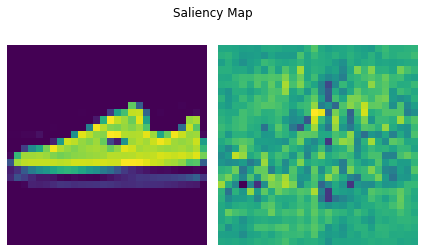

In [ ]:
# saliency map
def getSaliencyMap(index = 0):
  model.eval()
  img, k = train_dataset[index]
  img = torch.tensor(img,dtype=torch.float,requires_grad=True)
  x = img.unsqueeze(0).unsqueeze(1).to(device)
  model.eval()
  pred = model.forward(x).squeeze()
  loss = -pred[k.long()] # criterion(pred,k.unsqueeze(0).to(device))
  loss.backward()
  return img,img.grad
def plotSaliencyMap(index = 0):
  img,grad = getSaliencyMap(index)
  fig, ax = plt.subplots(1, 2)
  ax[0].imshow(img.detach())
  ax[0].axis('off')
  ax[1].imshow(grad)
  ax[1].axis('off')
  plt.tight_layout()
  fig.suptitle("Saliency Map")
  plt.show()
plotSaliencyMap(index=9999)

In [ ]:
def generate_image(k,label = 9):
  model.eval()
  img= torch.zeros((1, 1, 28, 28), requires_grad=True,device='cuda')
  _optimizer = torch.optim.Adam([img],lr = 0.001)
  # x = img.to(device)
  lamda = 0.2
  for i in range(1000):
    if k == 0:
      output = model.conv1(img)
      loss = -torch.sum(output[0][label]) #
    elif k == 1:
      output = model.conv1(img)
      output = model.conv2(output)
      output = model.conv3(output)
      output = model.dp1(output)
      output = model.mlp1(output.view(-1))
      loss = -output[label]
    elif k == 2:
      output = model(img)
      loss = -output[0][label]
    elif k == 3:
      output = model(img)
      loss = - (output[0][label] - lamda * torch.sum(abs(img)))
    elif k == 4:
      output = model(img)
      loss = - (output[0][label] - lamda * torch.sum(img ** 2))
    _optimizer.zero_grad()
    loss.backward()
    _optimizer.step()
    # x.zero_grad()
    # x -= normalize(img.grad.cuda()) * 0.005
  return img.cpu().detach()[0][0]
def visualize_filter():
  images = [ generate_image(i) for i in range(5)]
  plt.subplot(2,3,1)
  plt.title('conv layer')
  plt.imshow(images[0])
  plt.subplot(2,3,2)
  plt.title('mlp layer')
  plt.imshow(images[1])
  plt.subplot(2,3,3)
  plt.title('output logits')
  plt.imshow(images[2])
  plt.subplot(2,3,4)
  plt.title('output logits with L1')
  plt.imshow(images[3])
  plt.subplot(2,3,5)
  plt.title('output logits with L2')
  plt.imshow(images[4])
  plt.tight_layout()
  plt.show()

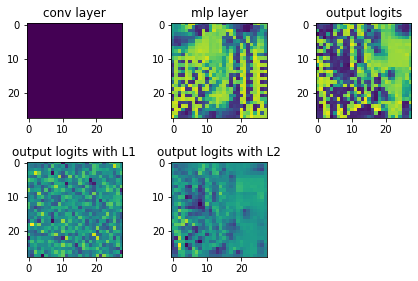

In [ ]:
visualize_filter()

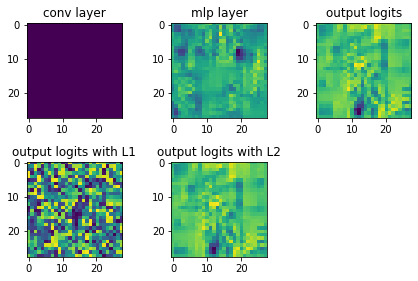

In [ ]:
def normalize(grad):
  return grad / (sum(grad)+1e-5)
def generate_image(k,label = 1):
  model.eval()
  img= torch.zeros((1, 1, 28, 28), requires_grad=True)
  x = img.cuda()
  x.retain_grad()
  lr = 0.005
  lamda = 0.2
  for i in range(1000):
    if k == 0:
      output = model.conv1(x)
      loss = -torch.sum(output[0][label]) #
    elif k == 1:
      output = model.conv1(x)
      output = model.conv2(output)
      output = model.conv3(output)
      output = model.dp1(output)
      output = model.mlp1(output.view(-1))
      loss = -output[label]
    elif k == 2:
      output = model(x)
      loss = -output[0][label]
    elif k == 3:
      output = model(x)
      loss = - (output[0][label] - lamda * torch.sum(abs(x)))
    elif k == 4:
      output = model(x)
      loss = - (output[0][label] - lamda * torch.sum(x ** 2))
    loss.backward()
    x -= x.grad.cuda() * lr
    x.grad.zero_()
  return x.cpu().detach()[0][0]
def visualize_filter():
  images = [ generate_image(i) for i in range(5)]
  plt.subplot(2,3,1)
  plt.title('conv layer')
  plt.imshow(images[0])
  plt.subplot(2,3,2)
  plt.title('mlp layer')
  plt.imshow(images[1])
  plt.subplot(2,3,3)
  plt.title('output logits')
  plt.imshow(images[2])
  plt.subplot(2,3,4)
  plt.title('output logits with L1')
  plt.imshow(images[3])
  plt.subplot(2,3,5)
  plt.title('output logits with L2')
  plt.imshow(images[4])
  plt.tight_layout()
  plt.show()
visualize_filter()